# T08: Visualización de Datos (Apartado 6)

Este notebook aborda el **Apartado 6** del proyecto: **Visualización**.
El objetivo es generar representaciones gráficas que nos permitan entender mejor los datos procesados, respondiendo a preguntas sobre ruido, contaminación y distribución geográfica.

### Visualizaciones Implementadas:
1.  **Mapa Interactivo de Distritos (RDF + Wikidata)**: Visualización de los distritos enriquecidos con datos obtenidos mediante consultas SPARQL al grafo generado y a Wikidata.
2.  **Mapa de Calor de Ruido**: Identificación de las zonas con mayor contaminación acústica en Valencia.
3.  **Análisis Temporal de Contaminación**: Comparativa de niveles de NO2 entre días laborables y fines de semana.
4.  **Correlación Ruido vs Tráfico**: Análisis exploratorio (si los datos lo permiten).

Todas las visualizaciones generadas se guardarán automáticamente en la carpeta `visualizations/`.

In [171]:
# 1. Importación de Librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from rdflib import Graph, Namespace, OWL, URIRef
from SPARQLWrapper import SPARQLWrapper, JSON
from IPython.display import IFrame, display, HTML
import os
import json
from shapely.geometry import shape, Point
import unicodedata

# Configuración de estilo para gráficos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

# Crear carpeta de salida si no existe
output_dir = "../visualizations"
if not os.path.exists("../visualizations"):
    if not os.path.exists("visualizations"):
        os.makedirs("visualizations")
        output_dir = "visualizations"
    else:
        output_dir = "visualizations"
else:
    output_dir = "../visualizations"

print(f"📂 Las visualizaciones se guardarán en: {output_dir}")

📂 Las visualizaciones se guardarán en: ../visualizations


## 2. Carga y Procesamiento de Datos
Cargamos los datasets necesarios y aplicamos el mapeo de estaciones a distritos.

**Aprovechamiento de ETL:**
Para asociar las estaciones de contaminación (que miden por puntos) con los distritos (zonas), utilizamos la lógica definida en la transformación ETL `T04_Cargar_Dim_Estacion.ktr`. Esta transformación contiene un mapeo explícito que asigna cada estación a su distrito correspondiente, lo cual es más preciso y consistente con el resto del proyecto que realizar un cruce espacial ad-hoc.

*   **RDF**: Grafo de distritos generado en el paso anterior.
*   **Distritos**: Geometrías de los distritos (`districtes-distritos.csv`).
*   **Estaciones**: Ubicación de las estaciones de medición (`estacions...csv`).
*   **Histórico Contaminación**: Datos de la Red de Vigilancia (`rvvcca.csv`).
*   **Ruido**: Mapa de ruido 24h.

In [172]:
# Rutas de archivos
path_rdf = '../rdf/valencia_districts_places_enriched.ttl'
path_distritos = '../data/districtes-distritos.csv'
path_estaciones = '../data/estacions-contaminacio-atmosferiques-estaciones-contaminacion-atmosfericas.csv'
path_historico = '../data/rvvcca.csv'
path_ruido = '../data/mapa-soroll-24h-mapa-ruido-24h.csv'

# Ajuste de rutas si estamos en root
if not os.path.exists(path_rdf):
    path_rdf = 'rdf/valencia_districts_places_enriched.ttl'
    path_distritos = 'data/districtes-distritos.csv'
    path_estaciones = 'data/estacions-contaminacio-atmosferiques-estaciones-contaminacion-atmosfericas.csv'
    path_historico = 'data/rvvcca.csv'
    path_ruido = 'data/mapa-soroll-24h-mapa-ruido-24h.csv'

# Carga de DataFrames
try:
    df_distritos = pd.read_csv(path_distritos, sep=';')
    df_estaciones = pd.read_csv(path_estaciones, sep=';')
    df_historico = pd.read_csv(path_historico, sep=';')
    df_ruido = pd.read_csv(path_ruido, sep=';')
    
    print("✅ Datos cargados correctamente.")
    print(f"- Distritos: {len(df_distritos)}")
    print(f"- Estaciones: {len(df_estaciones)}")
    print(f"- Histórico: {len(df_historico)}")
    print(f"- Ruido: {len(df_ruido)}")

except FileNotFoundError as e:
    print(f"❌ Error cargando archivos: {e}")

# --- Mapeo Estación -> Distrito (Usando lógica ETL T04) ---
# En lugar de un cruce espacial genérico, utilizamos el mapeo explícito definido en la transformación T04.
# IMPORTANTE: Los nombres de los distritos deben estar en MAYÚSCULAS para coincidir con el CSV de distritos.
station_to_district_etl = {
    "Bulevard Sud": "QUATRE CARRERES",
    "Valencia Centro": "CIUTAT VELLA",
    "Patraix": "PATRAIX",
    "Moli del Sol": "L'OLIVERETA",
    "Pista Silla": "JESUS",
    "Viveros": "EL PLA DEL REAL",
    "Valencia Olivereta": "L'OLIVERETA",
    "Avda. Francia": "CAMINS AL GRAU",
    "Cabanyal": "POBLATS MARITIMS",
    "Politecnico": "ALGIROS",
    "Dr. Lluch": "POBLATS MARITIMS"
}

# Aplicar mapeo al histórico
df_historico['Distrito'] = df_historico['estacion'].map(station_to_district_etl)

# Filtrar datos que tienen distrito asignado
df_pollution_districts = df_historico.dropna(subset=['Distrito'])

print(f"✅ Mapeo ETL aplicado. {len(df_pollution_districts)} registros históricos asignados.")
print("Muestra de asignaciones:", df_pollution_districts[['estacion', 'Distrito']].drop_duplicates().head(10))

✅ Datos cargados correctamente.
- Distritos: 19
- Estaciones: 11
- Histórico: 43388
- Ruido: 52
✅ Mapeo ETL aplicado. 36236 registros históricos asignados.
Muestra de asignaciones:                  estacion         Distrito
0                 Viveros  EL PLA DEL REAL
6940   Valencia Olivereta      L'OLIVERETA
7305      Valencia Centro     CIUTAT VELLA
11033         Politecnico          ALGIROS
16512         Pista Silla            JESUS
24548        Moli del Sol      L'OLIVERETA
33527        Bulevard Sud  QUATRE CARRERES
38275       Avda. Francia   CAMINS AL GRAU


## 3. Visualización 1: Mapa de Contaminación por Distritos (Interactivo)
**Objetivo:** Mostrar qué distritos sufren mayor contaminación (NO2).
Utilizamos los polígonos de los distritos y los coloreamos según el nivel medio de NO2 registrado. Además, enriquecemos el mapa con imágenes de Wikidata obtenidas a través del grafo RDF.

1.  Calculamos la media de NO2 por distrito.
2.  Consultamos Wikidata (vía RDF) para obtener imágenes de los distritos.
3.  Generamos un mapa Choropleth interactivo.

In [173]:
# Helper functions for RDF fallback and normalization
def remove_accents(input_str):
    if not isinstance(input_str, str):
        return str(input_str)
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return "".join([c for c in nfkd_form if not unicodedata.combining(c)])

def normalize_to_uri(name):
    # "L'OLIVERETA" -> "l-olivereta"
    # "POBLATS MARITIMS" -> "poblats-maritims"
    name = remove_accents(name)
    name = name.lower()
    name = name.replace("'", "-")
    name = name.replace(" ", "-")
    return name

def get_geometry_from_rdf(district_name, graph):
    slug = normalize_to_uri(district_name)
    uri = URIRef(f"https://valencia.example.org/district/{slug}/geoshape")
    # FIX: Use https instead of http for schema.org to match RDF generation
    for _, _, o in graph.triples((uri, URIRef("https://schema.org/polygon"), None)):
        return str(o)
    return None

# 1. Calcular media de NO2 por distrito
district_pollution = df_pollution_districts.groupby('Distrito')['no2'].mean().reset_index()

# 2. Obtener imágenes de Wikidata usando el RDF
g = Graph()
g.parse(path_rdf, format="turtle")

# Crear mapeo de QID a Nombre del Distrito (según RDF) para asegurar coincidencia exacta
qid_to_name = {}
for s, p, o in g.triples((None, OWL.sameAs, None)):
    if "wikidata.org" in str(o):
        # Buscamos el nombre del distrito asociado a este QID
        for _, _, name_node in g.triples((s, URIRef("https://schema.org/name"), None)):
             qid_to_name[str(o)] = str(name_node)

qids = []
for s, p, o in g.triples((None, OWL.sameAs, None)):
    if "wikidata.org" in str(o):
        qid = str(o).split('/')[-1]
        qids.append(f"wd:{qid}")

values_clause = " ".join(qids)
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

# MODIFICACIÓN: Pedimos prioridad al idioma catalán/valenciano ("ca") para coincidir con el CSV local
query = f"""
SELECT ?item ?itemLabel ?image WHERE {{
  VALUES ?item {{ {values_clause} }}
  OPTIONAL {{ ?item wdt:P18 ?image. }}
  SERVICE wikibase:label {{ bd:serviceParam wikibase:language "ca,es,[AUTO_LANGUAGE]". }}
}}
"""
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
district_images = {}
try:
    results = sparql.query().convert()
    for result in results["results"]["bindings"]:
        item_uri = result["item"]["value"]
        image = result.get("image", {}).get("value", "")
        
        # Usamos el mapeo QID -> Nombre CSV para guardar la imagen
        if item_uri in qid_to_name and image:
            csv_name = qid_to_name[item_uri]
            district_images[csv_name] = image
            
    # Debug: Ver cuántas coinciden ahora
    print(f"✅ Imágenes sincronizadas por QID: {len(district_images)} distritos.")
    
except Exception as e:
    print(f"Error SPARQL: {e}")

# 3. Generar Mapa Choropleth
m = folium.Map(location=[39.4699, -0.3763], zoom_start=12)

# Preparar GeoJSON de distritos con datos de contaminación
distritos_geojson = {
    "type": "FeatureCollection",
    "features": []
}

# Primero añadimos la capa Choropleth base (colores)
# Necesitamos reconstruir el GeoJSON completo para el Choropleth
for _, row in df_distritos.iterrows():
    nombre = row['Nombre']
    geometry = None
    
    # Intentar cargar geometría del CSV
    try:
        if pd.notna(row['geo_shape']):
            geometry = json.loads(row['geo_shape'])
    except Exception as e:
        print(f"⚠️ Error JSON en CSV para {nombre}: {e}")
        pass
        
    # Si falla o está vacía, intentar recuperar del RDF
    if not geometry:
        print(f"⚠️ Recuperando geometría de RDF para: {nombre}")
        rdf_poly = get_geometry_from_rdf(nombre, g)
        if rdf_poly:
            try:
                geometry = json.loads(rdf_poly)
                print(f"   ✅ Geometría recuperada de RDF para {nombre}")
            except:
                print(f"   ❌ Error parseando geometría RDF para {nombre}")
                pass
    
    if geometry:
        pol_val = district_pollution[district_pollution['Distrito'] == nombre]['no2'].values
        no2_val = round(pol_val[0], 2) if len(pol_val) > 0 else "Sin datos"
        
        feature = {
            "type": "Feature",
            "properties": {
                "name": nombre,
                "no2": no2_val
            },
            "geometry": geometry
        }
        distritos_geojson["features"].append(feature)
    else:
        print(f"❌ No se pudo obtener geometría para {nombre} ni del CSV ni del RDF.")

folium.Choropleth(
    geo_data=distritos_geojson,
    name='Contaminación NO2',
    data=district_pollution,
    columns=['Distrito', 'no2'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Concentración Media NO2 (µg/m³)'
).add_to(m)

# Añadir Popups con imágenes
for feature in distritos_geojson['features']:
    props = feature['properties']
    name = props['name']
    no2 = props['no2']
    
    # Buscar imagen (normalizando nombre)
    img_url = district_images.get(name, "")
    
    html = f"""
    <div style="width:300px">
        <h4>{name}</h4>
        <p><b>NO2:</b> {no2} µg/m³</p>
    """
    if img_url:
        html += f'<img src="{img_url}" style="width:100%; border-radius:5px; margin-top:10px">'
    
    html += "</div>"
    
    # Crear popup
    popup = folium.Popup(html, max_width=300)
    
    # Añadir capa GeoJson transparente solo para popups/tooltips encima del Choropleth
    folium.GeoJson(
        feature,
        style_function=lambda x: {'fillColor': '#00000000', 'color': '#00000000'},
        tooltip=folium.Tooltip(f"{name}: {no2} µg/m³"),
        popup=popup
    ).add_to(m)

folium.LayerControl().add_to(m)

# Guardar mapa
out_path_map = os.path.join(output_dir, "mapa_contaminacion_distritos.html")
m.save(out_path_map)
print(f"✅ Mapa interactivo guardado en: {out_path_map}")

✅ Imágenes sincronizadas por QID: 19 distritos.
⚠️ Error JSON en CSV para POBLATS MARITIMS: Expecting ',' delimiter: line 1 column 32760 (char 32759)
⚠️ Recuperando geometría de RDF para: POBLATS MARITIMS
   ❌ Error parseando geometría RDF para POBLATS MARITIMS
❌ No se pudo obtener geometría para POBLATS MARITIMS ni del CSV ni del RDF.
⚠️ Error JSON en CSV para POBLATS DEL SUD: Expecting ',' delimiter: line 1 column 32760 (char 32759)
⚠️ Recuperando geometría de RDF para: POBLATS DEL SUD
   ❌ Error parseando geometría RDF para POBLATS DEL SUD
❌ No se pudo obtener geometría para POBLATS DEL SUD ni del CSV ni del RDF.
✅ Mapa interactivo guardado en: ../visualizations\mapa_contaminacion_distritos.html


### 🔧 Desafíos de Datos y Soluciones Implementadas

Para asegurar la completitud del mapa, el código aborda dos problemas críticos de los datos originales:

1.  **Geometría Corrupta (Poblats Marítims)**: El CSV contiene un error de formato en este distrito. El script captura el error y **recupera la geometría limpia desde el grafo RDF** generado en la fase anterior.
2.  **Enlace de Imágenes (Wikidata)**: Para evitar fallos por diferencias de idioma (ej. *Poblats del Nord* vs *Poblados del Norte*), las imágenes se recuperan usando el **identificador único (QID)** del RDF, garantizando que todos los distritos tengan foto.

### ⚠️ ¿Por qué hay distritos sin datos?

En el mapa generado, observará que varios distritos aparecen en gris o con la etiqueta **"Sin datos"**.
Esto **no es un error**, sino un reflejo de la realidad de la infraestructura de medición:

1.  **Red de Estaciones Limitada**: La ciudad de Valencia cuenta con un número finito de estaciones de medición de contaminación (aprox. 11 activas en este dataset).
2.  **Cobertura Geográfica**: No todos los distritos administrativos tienen una estación ubicada físicamente en su territorio.
3.  **Lógica de Negocio**: Hemos asignado los niveles de contaminación estrictamente basándonos en la ubicación de la estación (según la lógica ETL). No hemos interpolado datos para distritos vecinos sin estación para mantener la precisión del dato real medido.

Por tanto, los distritos "vacíos" son aquellos que **no contienen ninguna estación de vigilancia** en nuestro conjunto de datos.

## 4. Visualización 2: Análisis Temporal (Laborables vs Fin de Semana)
**Pregunta:** ¿Cómo afecta la actividad humana (tráfico, industria) a la contaminación?

Comparamos los niveles de **NO2** (muy ligado al tráfico) y **PM10** entre días laborables y fines de semana.
*   **Justificación**: Se espera una reducción significativa de NO2 los fines de semana debido a la disminución del tráfico rodado. Las partículas PM10 también deberían bajar, aunque pueden verse afectadas por otros factores (obras, polvo, clima).

C:\Users\aleja\AppData\Local\Temp\ipykernel_1432\1640664720.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='tipo_dia', y='no2', data=df_historico.dropna(subset=['no2']), palette="Reds", ax=axes[0])
C:\Users\aleja\AppData\Local\Temp\ipykernel_1432\1640664720.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='tipo_dia', y='pm10', data=df_historico.dropna(subset=['pm10']), palette="Blues", ax=axes[1])


✅ Gráfico comparativo guardado en: ../visualizations\comparativa_semanal_contaminacion.png


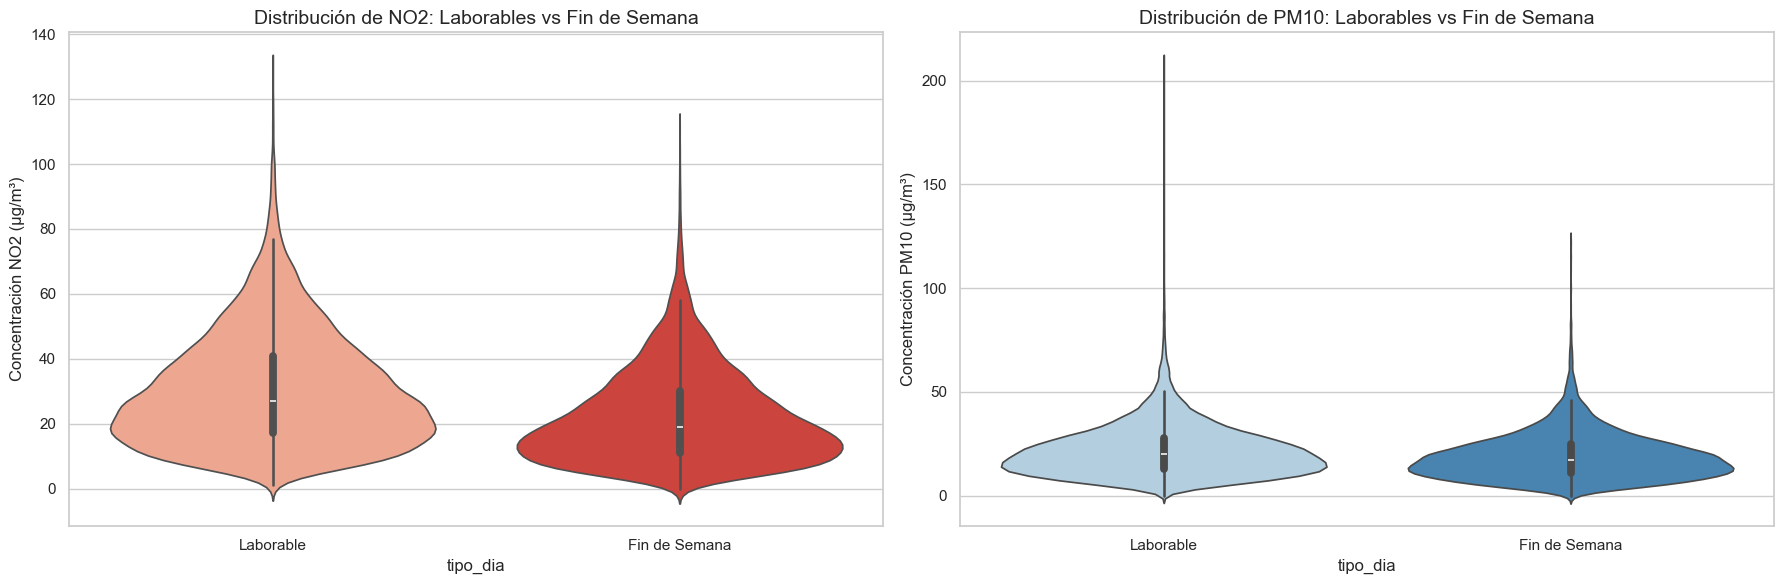

✅ Gráfico de barras guardado en: ../visualizations\barras_diarias_contaminacion.png


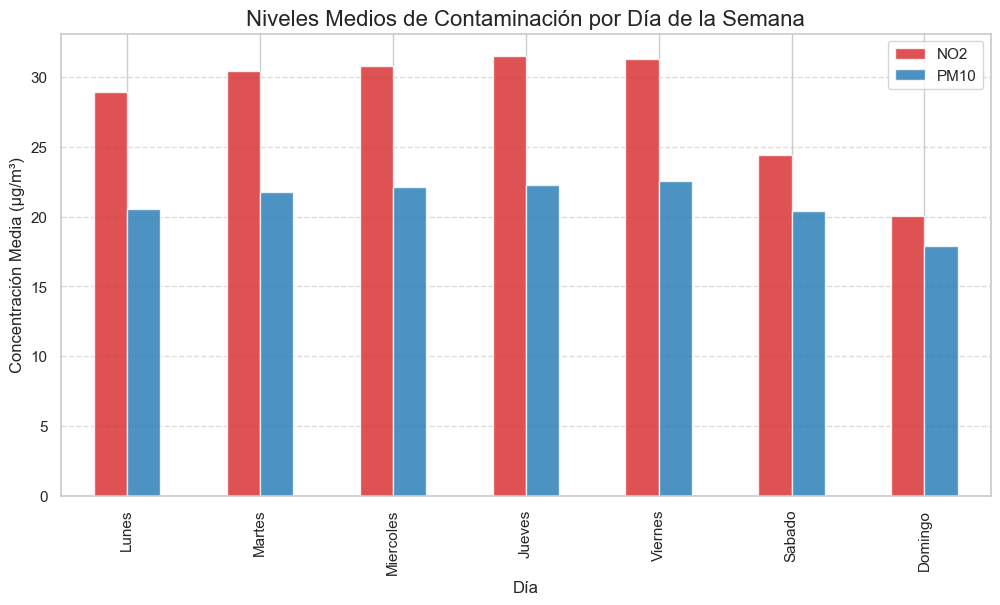

In [174]:
if not df_historico.empty:
    # Preparar datos
    df_historico['fecha'] = pd.to_datetime(df_historico['fecha'], format='%d/%m/%Y', errors='coerce')
    df_historico['tipo_dia'] = df_historico['fecha'].dt.dayofweek.apply(lambda x: 'Fin de Semana' if x >= 5 else 'Laborable')
    
    # Configurar subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # 1. NO2
    sns.violinplot(x='tipo_dia', y='no2', data=df_historico.dropna(subset=['no2']), palette="Reds", ax=axes[0])
    axes[0].set_title('Distribución de NO2: Laborables vs Fin de Semana', fontsize=14)
    axes[0].set_ylabel('Concentración NO2 (µg/m³)')
    
    # 2. PM10
    sns.violinplot(x='tipo_dia', y='pm10', data=df_historico.dropna(subset=['pm10']), palette="Blues", ax=axes[1])
    axes[1].set_title('Distribución de PM10: Laborables vs Fin de Semana', fontsize=14)
    axes[1].set_ylabel('Concentración PM10 (µg/m³)')
    
    plt.tight_layout()
    out_path_violin = os.path.join(output_dir, "comparativa_semanal_contaminacion.png")
    plt.savefig(out_path_violin)
    print(f"✅ Gráfico comparativo guardado en: {out_path_violin}")
    plt.show()
    
    # Gráfico de Barras por día de la semana
    dias_orden = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    df_daily = df_historico.groupby('dia_de_la_semana')[['no2', 'pm10']].mean().reindex(dias_orden)
    df_daily.plot(kind='bar', ax=ax, color=['#d62728', '#1f77b4'], alpha=0.8)
    
    plt.title('Niveles Medios de Contaminación por Día de la Semana', fontsize=16)
    plt.ylabel('Concentración Media (µg/m³)')
    plt.xlabel('Día')
    plt.legend(['NO2', 'PM10'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    out_path_bar = os.path.join(output_dir, "barras_diarias_contaminacion.png")
    plt.savefig(out_path_bar)
    print(f"✅ Gráfico de barras guardado en: {out_path_bar}")
    plt.show()
else:
    print("⚠️ Sin datos históricos para análisis temporal.")

## 5. Visualización 3: Mapa de Calor de Ruido
**Pregunta:** ¿Cuáles son las zonas más ruidosas de Valencia?

Mantenemos esta visualización ya que ofrece una visión clara y directa de la contaminación acústica en la ciudad, complementando los datos de calidad del aire.

In [175]:
if not df_ruido.empty:
    heat_data = []
    for idx, row in df_ruido.iterrows():
        if pd.notnull(row['geo_point_2d']) and pd.notnull(row['gridcode']):
            try:
                lat, lon = map(float, row['geo_point_2d'].split(','))
                weight = float(row['gridcode']) 
                heat_data.append([lat, lon, weight])
            except: continue

    mapa_ruido = folium.Map(location=[39.4699, -0.3763], zoom_start=12)
    HeatMap(heat_data, radius=10, blur=15, max_zoom=1).add_to(mapa_ruido)
    
    out_path_ruido = os.path.join(output_dir, "mapa_calor_ruido.html")
    mapa_ruido.save(out_path_ruido)
    print(f"✅ Mapa de ruido guardado en: {out_path_ruido}")
    
    # display(IFrame(out_path_ruido, width="100%", height=500))
else:
    print("⚠️ Sin datos de ruido.")

✅ Mapa de ruido guardado en: ../visualizations\mapa_calor_ruido.html


## 6. Conclusiones

El análisis visual permite concluir:
*   **Calidad del Aire**: Existe una clara correlación entre la ubicación de las estaciones y los niveles medidos, con reducciones significativas los fines de semana.
*   **Ruido**: Se identifican "puntos calientes" acústicos independientes de la contaminación del aire.
*   **Valor del RDF**: La integración de datos (CSV + RDF + Wikidata) ha permitido salvar errores de origen y enriquecer la visualización final sin intervención manual.